# Creating a simple cell optimisation

This notebook will explain how to set up an optimisation of simple single compartmental cell with two free parameters that need to be optimised

In [1]:
# Install matplotlib if needed
!pip install matplotlib

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload

First we need to import the module that contains all the functionality to create electrical cell models

In [3]:
import bluepyopt as bpop
import bluepyopt.ephys as ephys

If you want to see a lot of information about the internals, 
the verbose level can be set to 'debug' by commenting out
the following lines

In [4]:
# import logging
# logger = logging.getLogger()
# logger.setLevel(logging.DEBUG)

Setting up a cell template
-------------------------
First a template that will describe the cell has to be defined. A template consists of:
* a morphology
* model mechanisms
* model parameters

### Creating a morphology
A morphology can be loaded from a file (SWC or ASC).

In [5]:
morph = ephys.morphologies.NrnFileMorphology('simple.swc')

By default a Neuron morphology has the following sectionlists: somatic, axonal, apical and basal. Let's create an object that points to the somatic sectionlist. This object will be used later to specify where mechanisms have to be added etc.

In [6]:
somatic_loc = ephys.locations.NrnSeclistLocation('somatic', seclist_name='somatic')

### Creating a mechanism

Now we can add ion channels to this morphology. Let's add the default Neuron Hodgkin-Huxley mechanism to the soma. 

In [7]:
hh_mech = ephys.mechanisms.NrnMODMechanism(
        name='hh',
        suffix='hh',
        locations=[somatic_loc])

The 'name' field can be chosen by the user, this name should be unique. The 'suffix' points to the same field in the NMODL file of the channel. 'locations' specifies which sections the mechanism will be added to.

### Creating parameters

Next we need to specify the parameters of the model. A parameter can be in two states: frozen and not-frozen. When a parameter is frozen it has an exact value, otherwise it only has some bounds but the exact value is not known yet.
Let's define first a parameter that sets the capacitance of the soma to a frozen value

In [8]:
cm_param = ephys.parameters.NrnSectionParameter(
        name='cm',
        param_name='cm',
        value=1.0,
        locations=[somatic_loc],
        frozen=True)

And parameters that represent the maximal conductance of the sodium and potassium channels. These two parameters will be optimised later.

In [9]:
gnabar_param = ephys.parameters.NrnSectionParameter(                                    
        name='gnabar_hh',
        param_name='gnabar_hh',
        locations=[somatic_loc],
        bounds=[0.05, 0.125],
        frozen=False)     
gkbar_param = ephys.parameters.NrnSectionParameter(
        name='gkbar_hh',
        param_name='gkbar_hh',
        bounds=[0.01, 0.075],
        locations=[somatic_loc],
        frozen=False)

### Creating the template

To create the cell template, we pass all these objects to the constructor of the template

In [10]:
simple_cell = ephys.models.CellModel(
        name='simple_cell',
        morph=morph,
        mechs=[hh_mech],
        params=[cm_param, gnabar_param, gkbar_param])  

Now we can print out a description of the cell

In [11]:
print(simple_cell)

simple_cell:
  morphology:
    simple.swc
  mechanisms:
    hh: hh at ['somatic']
  params:
    cm: ['somatic'] cm = 1.0
    gnabar_hh: ['somatic'] gnabar_hh = [0.05, 0.125]
    gkbar_hh: ['somatic'] gkbar_hh = [0.01, 0.075]



With this cell we can build a cell evaluator.

## Setting up a cell evaluator

To optimise the parameters of the cell we need to create cell evaluator object. 
This object will need to know which protocols to inject, which parameters to optimise, etc.

### Creating the protocols

A protocol consists of a set of stimuli, and a set of responses (i.e. recordings). These responses will later be used to calculate
the score of the parameter values.
Let's create two protocols, two square current pulses at somatic`[0]`(0.5) with different amplitudes.
We first need to create a location object

In [12]:
soma_loc = ephys.locations.NrnSeclistCompLocation(
        name='soma',
        seclist_name='somatic',
        sec_index=0,
        comp_x=0.5)


and then the stimuli, recordings and protocols. For each protocol we add a recording and a stimulus in the soma.

In [13]:
sweep_protocols = []
for protocol_name, amplitude in [('step1', 0.01), ('step2', 0.05)]:
    stim = ephys.stimuli.NrnSquarePulse(
                step_amplitude=amplitude,
                step_delay=100,
                step_duration=50,
                location=soma_loc,
                total_duration=200)
    rec = ephys.recordings.CompRecording(
            name='%s.soma.v' % protocol_name,
            location=soma_loc,
            variable='v')
    protocol = ephys.protocols.SweepProtocol(protocol_name, [stim], [rec])
    sweep_protocols.append(protocol)
twostep_protocol = ephys.protocols.SequenceProtocol('twostep', protocols=sweep_protocols)

### Running a protocol on a cell

Now we're at a stage where we can actually run a protocol on the cell. We first need to create a Simulator object.

In [14]:
nrn = ephys.simulators.NrnSimulator()

The run() method of a protocol accepts a cell model, a set of parameter values and a simulator

In [15]:
default_params = {'gnabar_hh': 0.1, 'gkbar_hh': 0.03}
responses = twostep_protocol.run(cell_model=simple_cell, param_values=default_params, sim=nrn)

Plotting the response traces is now easy:

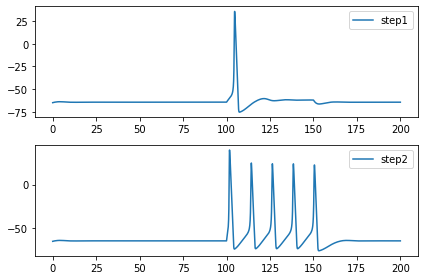

In [16]:
def plot_responses(responses):
    plt.subplot(2,1,1)
    plt.plot(responses['step1.soma.v']['time'], responses['step1.soma.v']['voltage'], label='step1')
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(responses['step2.soma.v']['time'], responses['step2.soma.v']['voltage'], label='step2')
    plt.legend()
    plt.tight_layout()

plot_responses(responses)

As you can see, when we use different parameter values, the response looks different.

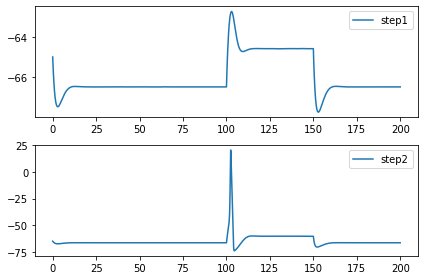

In [17]:
other_params = {'gnabar_hh': 0.05, 'gkbar_hh': 0.05}
plot_responses(twostep_protocol.run(cell_model=simple_cell, param_values=other_params, sim=nrn))

### Defining eFeatures and objectives

For every response we need to define a set of eFeatures we will use for the fitness calculation later. We have to combine features together into objectives that will be used by the optimalisation algorithm. In this case we will create one objective per feature:

In [18]:
efel_feature_means = {'step1': {'Spikecount': 1}, 'step2': {'Spikecount': 5}}

objectives = []

for protocol in sweep_protocols:
    stim_start = protocol.stimuli[0].step_delay
    stim_end = stim_start + protocol.stimuli[0].step_duration
    for efel_feature_name, mean in efel_feature_means[protocol.name].items():
        feature_name = '%s.%s' % (protocol.name, efel_feature_name)
        feature = ephys.efeatures.eFELFeature(
                    feature_name,
                    efel_feature_name=efel_feature_name,
                    recording_names={'': '%s.soma.v' % protocol.name},
                    stim_start=stim_start,
                    stim_end=stim_end,
                    exp_mean=mean,
                    exp_std=0.05 * mean)
        objective = ephys.objectives.SingletonObjective(
            feature_name,
            feature)
        objectives.append(objective)

### Creating the cell evaluator

We will need an object that can use these objective definitions to calculate the scores from a protocol response. This is called a ScoreCalculator.

In [19]:
score_calc = ephys.objectivescalculators.ObjectivesCalculator(objectives) 

Combining everything together we have a CellEvaluator. The CellEvaluator constructor has a field 'parameter_names' which contains the (ordered) list of names of the parameters that are used as input (and will be fitted later on).

In [20]:
cell_evaluator = ephys.evaluators.CellEvaluator(
        cell_model=simple_cell,
        param_names=['gnabar_hh', 'gkbar_hh'],
        fitness_protocols={twostep_protocol.name: twostep_protocol},
        fitness_calculator=score_calc,
        sim=nrn)


### Evaluating the cell

The cell can now be evaluate for a certain set of parameter values.

In [21]:
print(cell_evaluator.evaluate_with_dicts(default_params))

{'step1.Spikecount': 0.0, 'step2.Spikecount': 0.0}


## Setting up and running an optimisation

Now that we have a cell template and an evaluator for this cell, we can set up an optimisation.

In [22]:
optimisation = bpop.optimisations.DEAPOptimisation(
        evaluator=cell_evaluator,
        offspring_size = 10)

And this optimisation can be run for a certain number of generations

In [ ]:
final_pop, hall_of_fame, logs, hist = optimisation.run(max_ngen=5)

The optimisation has return us 4 objects: final population, hall of fame, statistical logs and history. 

The final population contains a list of tuples, with each tuple representing the two parameters of the model

In [ ]:
print('Final population: ', final_pop)

The best individual found during the optimisation is the first individual of the hall of fame

In [ ]:
best_ind = hall_of_fame[0]
print('Best individual: ', best_ind)
print('Fitness values: ', best_ind.fitness.values)

We can evaluate this individual and make use of a convenience function of the cell evaluator to return us a dict of the parameters

In [ ]:
best_ind_dict = cell_evaluator.param_dict(best_ind)
print(cell_evaluator.evaluate_with_dicts(best_ind_dict))

As you can see the evaluation returns the same values as the fitness values provided by the optimisation output. 
We can have a look at the responses now.

In [ ]:
plot_responses(twostep_protocol.run(cell_model=simple_cell, param_values=best_ind_dict, sim=nrn))
 

Let's have a look at the optimisation statistics.
We can plot the minimal score (sum of all objective scores) found in every optimisation. 
The optimisation algorithm uses negative fitness scores, so we actually have to look at the maximum values log.

In [ ]:
import numpy
gen_numbers = logs.select('gen')
min_fitness = logs.select('min')
max_fitness = logs.select('max')
plt.plot(gen_numbers, min_fitness, label='min fitness')
plt.xlabel('generation #')
plt.ylabel('score (# std)')
plt.legend()
plt.xlim(min(gen_numbers) - 1, max(gen_numbers) + 1) 
plt.ylim(0.9*min(min_fitness), 1.1 * max(min_fitness)) 